The purpose of this script is to find "fads" or "hot topics" in fMRI research over time. It uses Kleinberg's "bursty stream analysis" to identify topics that are associated with a burst of popularity and characterize their popularity over time.

Kleinberg, 2002. Bursty and Hierarchical Structure in Streams
https://www.cs.cornell.edu/home/kleinber/bhs.pdf



In [222]:
from Bio import Entrez
import string

#RETRIVE ARTICLES FROM PUBMED

#search PubMed for all articles with "fMRI" in the title or abstract
#code adapted from http://marcobonzanini.com/2015/01/12/searching-pubmed-with-python/
def search(query):
    Entrez.email = 'marinsek@dyns.ucsb.edu'
    handle = Entrez.esearch(db='pubmed', 
                            sort='recent',
                            retmax='20',
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results #returns list of article IDs 

#given a list of article IDs, find their associated titles, publication dates, and journals
def get_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'marinsek@dyns.ucsb.edu'
    #get title, publication date, and journal
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results #returns a list of MedlineCitation dictionaries

#retrieve articles containing "fMRI"
search_results = search('functional magnetic resonance imaging[Title/Abstract] OR fMRI[Title/Abstract]')
results = get_details(search_results['IdList'])


In [223]:
#CREATE AN ARTICLE CLASS
class Article:
    
    def __init__(self, title, title_words, journal, pub_year, pub_month):
        self.title = title
        self.title_words = title_words
        self.journal = journal
        self.pub_date = pub_month+pub_year


In [224]:
#ORGANIZE DATA AND PREPROCESS ARTICLE TITLES
import string
from collections import defaultdict

#create a dictionary to hold all of the articles
#keys: publication date (ex. APR2016), values: list of Article objects
articles = defaultdict(list)

articles_used = 0
articles_rejected = 0

#loop through results
for result in results:
    
    #only add articles with known publication dates, journals, and titles
    try:
    
        #populate an Article object based on the result
        #Article(title, title_words, journal, pub_year, pub_month)
        a = Article(result['MedlineCitation']['Article']['ArticleTitle'],
                    [],
                    result['MedlineCitation']['Article']['Journal']['Title'],
                    result['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'],
                    result['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Month'].upper())
    
    except:
        
        articles_rejected += 1
    
    else:
        
        #preprocess the words in the title
        words = a.title.lower().split()     #convert all words to lowercase and parse
        words = [word.strip(string.punctuation) for word in words]  #remove leading and trailing punctuation 
        a.title_words = words               #add the list of words to the Article object

        #add the Article object to the articles dictionary (add to appropriate month)
        articles[a.pub_date].append(a)
        
        articles_used += 1
        
print articles_used
print articles_rejected


16
4


In [233]:
#RUN BURSTY ANALYSIS

import sympy.functions.combinatorial.factorials as c
from numpy import log
import pandas as pd

#define s: resolution of state jumps, lower s --> more bursty
s = 1.5

#create a list of all unique words in the article titles
unique_words = []
for month in articles:                      #loop through months
    for a in articles[month]:               #loop through articles in each month
        for word in a.title_words:          #loop through words in each article title
            if word not in unique_words:    
                unique_words.append(word)   #add new words to unique_words list

#define variables
r = {}              #number of relevant papers in month t
d = {}              #number of papers in month t
p = {}              #proportion of relevant papers in month t
w = {}              #weight of transition from t to t+1
cost_diff = {}
start_yr = 2016
end_yr = 2016
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
skipped = 0
index = ['MAR2016','APR2016']
weights = pd.DataFrame(index=index)

                
#loop through all unique words
for word in unique_words:
    
    #loop through each month (t) and find proportions
    for month in articles:
        
        #calculate rt: titles containing WORD in MONTH
        r[month] = sum([1 for article in articles[month] if word in article.title_words])
        
        #calculate dt: titles in MONTH
        d[month] = len(articles[month])
        
        #calculate pt: proportion of titles containing WORD in MONTH
        p[month] = rt[month] / float(dt[month])
        
    #calculate R: total titles containing WORD
    R = sum(rt.values())
    
    #calculate D: total titles
    D = sum(dt.values())
    
    #calculate p0: baseline proportion of titles containing WORD --> "expected" proportion
    p0 = R / float(D)
    
    #calculate p1: estimated proportion of titles containing WORD during a burst
    p1 = P * s
    
    #calculate transition weights from month to month
    #**** need to make sure this is done in the correct order***
    t = 'JAN2015'
    first = True
    for year in range(start_yr,end_yr+1):
        for month in months:
            
            #define timepoint
            prev_t = t
            t = month + str(year)
            
            #skip months with no papers
            try:
                d[t]
            except:
                skipped += 1
            else:
                
                #calculate cost for q0 (formula on pg. 14)
                cost_q0 = -log(float(c.binomial(d[t],r[t]) * (p0**r[t]) * (1-p0)**(d[t]-r[t])))

                #calculate cost for q1
                cost_q1 = -log(float(c.binomial(d[t],r[t]) * (p1**r[t]) * (1-p1)**(d[t]-r[t])))

                #calculate weight of burst (== improvement in cost for q1 compared to q0)
                cost_diff[t] = cost_q0 - cost_q1

                #calculate weight between t-1 and t (skip for first loop, since t-1 is out of bounds)
                if first == True:
                    first = False
                else:
                    #calculate weight between t-1 and t
                    w[t] = cost_diff[prev_t] + cost_diff[t]
                    
    #add weights to the dataframe
    weights[word] = w.values()



         ipsilesional    anodal      tdcs  enhances       the  functional  \
MAR2016      0.371564  0.371564  0.371564  0.371564  0.810930    0.371564   
APR2016     -0.069157 -0.069157 -0.069157 -0.069157  0.809577    2.127677   

         benefits        of  rehabilitation        in     ...        imagery  \
MAR2016  0.371564  0.810930        0.371564  0.810930     ...      -0.067803   
APR2016 -0.069157  3.445777       -0.069157  3.445777     ...      -0.069157   

              via  parahippocampal  differential   sensory  signatures  \
MAR2016 -0.067803        -0.067803     -0.067803 -0.067803   -0.067803   
APR2016 -0.069157        -0.069157     -0.069157 -0.069157   -0.069157   

           autism  amplitude  trial-to-trial  variability  
MAR2016 -0.067803  -0.067803       -0.067803    -0.067803  
APR2016 -0.069157  -0.069157       -0.069157    -0.069157  

[2 rows x 134 columns]


Populating the interactive namespace from numpy and matplotlib


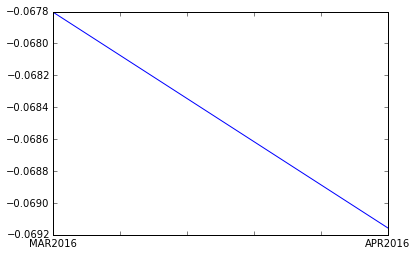

In [236]:
#IDENTIFY WORDS WITH HIGHEST WEIGHTS
%pylab inline 

weights['treatment'].plot()
